In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import torch
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer 
%matplotlib inline

In [19]:
dataframe=pd.read_csv('C:\Users\Jimmy_03\Desktop\College\Learning from Data\weatherHistory.csv')
dataframe=dataframe.dropna()

In [20]:
print(dataframe.duplicated().value_counts()) #Checking duplicates
dataframe=dataframe.drop_duplicates() #Dropping duplicates

False    95912
True        24
dtype: int64


In [21]:
dataframe['Precip Type'].fillna("rain", inplace = True)
print(dataframe.duplicated().value_counts()) #Verifying

False    95912
dtype: int64


In [22]:
dataframe=dataframe.reset_index(drop=True) #Reset index after each drop to eliminate errors

In [23]:
dataframe.loc[dataframe.index[dataframe['Pressure (millibars)']<=0].tolist(), ['Pressure (millibars)']] =np.nan  #missing values

In [24]:
imputer = SimpleImputer()  #completing missing values with simple strategies
imputer.fit(dataframe[['Pressure (millibars)']])
dataframe['Pressure (millibars)']=imputer.fit_transform(dataframe[['Pressure (millibars)']])

In [25]:
print(dataframe['Pressure (millibars)'].isnull().sum() ) # =0
dataframe.drop(dataframe[dataframe['Humidity'] == 0].index, inplace = True) #Drop outliers

dataframe=dataframe.reset_index(drop=True) #Reset index after each drop to eliminate errors

0


In [26]:
labelencoder =LabelEncoder()  #Encode target labels with value between 0 and n_classes-1
dataframe['Precip Type Encoded']=labelencoder.fit_transform(dataframe['Precip Type']) 
dataframe = dataframe.drop('Precip Type', axis = 1) 
dataframe['Summary Encoded']=labelencoder.fit_transform(dataframe['Summary'])
dataframe = dataframe.drop('Summary', axis = 1)

In [27]:
disc = KBinsDiscretizer(n_bins=16, encode='ordinal', strategy='uniform')  # encode the transformed result
disc.fit(dataframe[['Wind Bearing (degrees)']])
dataframe['Wind Bearing (degrees)'] = disc.transform(dataframe[['Wind Bearing (degrees)']])
dataframe['Wind Bearing Encoded']=labelencoder.fit_transform(dataframe['Wind Bearing (degrees)'])
dataframe = dataframe.drop('Wind Bearing (degrees)', axis = 1)

In [28]:
from sklearn.model_selection import train_test_split

#creating multi-dimensional matrix containing elements of a single data type.

X = torch.tensor(dataframe.drop(['Loud Cover','Precip Type Encoded','Formatted Date','Summary Encoded','Humidity','Daily Summary','Precip Type Encoded'], axis=1).values, dtype=torch.float)
y = torch.tensor(dataframe['Humidity'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)  #Sets the seed for generating random numbers to a non-deterministic random number
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)  #Returns a random permutation of integers from 0 to n - 1 

X, y = X[shuffle_idx], y[shuffle_idx]  

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

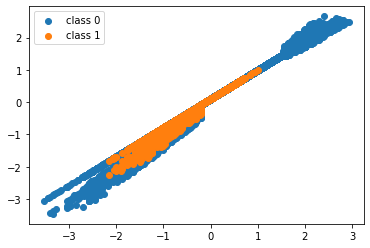

In [29]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

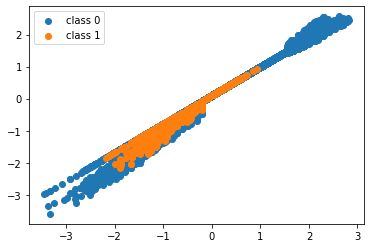

In [30]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

In [39]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias
    
    # Training and evaluation

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        # Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)  #Splits the tensor into chunks
        
        for minibatch_idx in minibatches:

            # Compute outputs
            yhat = model.forward(x[minibatch_idx])

            # Compute gradients
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            # Update weights
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            # Logging
            minibatch_loss = loss(yhat, y[minibatch_idx])
            #print('    Minibatch MSE: %.3f' % minibatch_loss)

        # Logging
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

In [32]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=10,
             learning_rate=0.0001,
             seed=123,
             minibatch_size=10)

    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.100
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.100
    Minibatch MSE: 0.100
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.100
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.100
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.100
    Minibatch MSE: 0.100
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000
    Minibatch MSE: 0.000


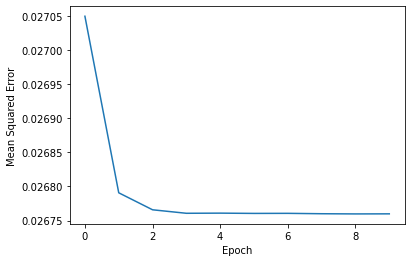

In [33]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [34]:
ones = torch.ones(y_train.size())  #Returns a tensor filled with the scalar value 1
zeros = torch.zeros(y_train.size())  
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 96.95
Test Accuracy: 97.09
